<a href="https://colab.research.google.com/github/pollinations/hive/blob/notebook-esrgan/Feed_Forward_VQGAN_CLIP_Using_a_pretrained_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feed Forward VQGAN_CLIP


Feed forward VQGAN-CLIP model, where the goal is to eliminate the need for optimizing the latent space of VQGAN for each input prompt. This is done by training a model that takes as input a text prompt, and returns as an output the VQGAN latent space, which is then transformed into an RGB image. The model is trained on a dataset of text prompts and can be used on unseen text prompts. The loss function is minimizing the distance between the CLIP generated image features and the CLIP input text features. Additionally, a diversity loss can be used to make increase the diversity of the generated images given the same prompt.

This notebooks shows how to use a pre-trained model for generating images.

In [27]:
super_resolution = True
output_path = "/content/output"

In [28]:
!mkdir -p $output_path

In [29]:
#@title Upscale images/video frames

loaded_upscale_model = False

def upscale(filepath):
  if not super_resolution:
    return
  global loaded_upscale_model
  if not loaded_upscale_model:
    # Clone Real-ESRGAN and enter the Real-ESRGAN
    !git clone https://github.com/xinntao/Real-ESRGAN.git /content
    %cd /content/Real-ESRGAN
    # Set up the environment
    !pip install basicsr
    !pip install facexlib
    !pip install gfpgan
    !pip install -r requirements.txt
    !python setup.py develop
    # Download the pre-trained model
    !wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.2.4/RealESRGAN_x4plus_anime_6B.pth -P experiments/pretrained_models
    %cd -
    loaded_upscale_model = True 
  
  %cd /content/Real-ESRGAN
  !python inference_realesrgan.py --model_path experiments/pretrained_models/RealESRGAN_x4plus_anime_6B.pth --input $filepath --netscale 4 --outscale 2 --half --output $output_path
  filepath_out = filepath.replace(".jpg","_out.jpg")
  !mv -v $filepath_out $filepath
  %cd -

In [30]:
%cd /content
!git clone https://github.com/mehdidc/feed_forward_vqgan_clip

/content
fatal: destination path 'feed_forward_vqgan_clip' already exists and is not an empty directory.


In [31]:
cd feed_forward_vqgan_clip

/content/feed_forward_vqgan_clip


In [32]:
!pip install -r requirements.txt

In [33]:
!sudo apt install aria2
from pathlib import Path
if not Path("vqgan_imagenet_f16_16384.yaml").exists():
    !aria2c -x 5 --auto-file-renaming=false 'https://github.com/mehdidc/feed_forward_vqgan_clip/releases/download/0.1/vqgan_imagenet_f16_16384.yaml' -o vqgan_imagenet_f16_16384.yaml
    !aria2c -x 5 --auto-file-renaming=false 'https://github.com/mehdidc/feed_forward_vqgan_clip/releases/download/0.1/vqgan_imagenet_f16_16384.ckpt' -o vqgan_imagenet_f16_16384.ckpt


if not Path("cc12m_32x1024.th").exists():
    !aria2c -x 5 --auto-file-renaming=false 'https://github.com/mehdidc/feed_forward_vqgan_clip/releases/download/0.1/cc12m_32x1024.th' -o cc12m_32x1024.th
#check available models at https://github.com/mehdidc/feed_forward_vqgan_clip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
aria2 is already the newest version (1.33.1-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


# Load model

---



In [34]:
from IPython.display import Image
import torch
import clip
from main import load_vqgan_model, CLIP_DIM, clamp_with_grad, synth
import torchvision

model_path = "cc12m_32x1024.th"
device = "cuda" if torch.cuda.is_available() else "cpu"
net = torch.load(model_path, map_location="cpu").to(device)
config = net.config
vqgan_config = config.vqgan_config 
vqgan_checkpoint = config.vqgan_checkpoint
clip_model = config.clip_model
clip_dim = CLIP_DIM
perceptor = clip.load(clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
model = load_vqgan_model(vqgan_config, vqgan_checkpoint).to(device)
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


# Generation of images from text

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (390/390), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 390 (delta 208), reused 279 (delta 110), pack-reused 0
Receiving objects: 100% (390/390), 3.20 MiB | 8.53 MiB/s, done.
Resolving deltas: 100% (208/208), done.
[Errno 2] No such file or directory: '/content/Real-ESRGAN'
/content/feed_forward_vqgan_clip
     |████████████████████████████████| 147 kB 9.7 MB/s 
     |████████████████████████████████| 5.8 MB 52.3 MB/s 
     |████████████████████████████████| 185 kB 46.9 MB/s 
  Created wheel for basicsr: filename=basicsr-1.3.4.2-py3-none-any.whl size=182172 sha256=0cd3fa4a7e38e4696e4b39223caee4b3fd069decaee506342ac3404be443559e
  Stored in directory: /root/.cache/pip/wheels/96/be/05/7e5677c7d34ee56a2a1e2f05e1ce26a0bf358c1e2fb5ee46c8
Successfully built basicsr


     |████████████████████████████████| 1.1 MB 8.4 MB/s 
     |████████████████████████████████| 177 kB 63.2 MB/s 
  Created wheel for facexlib: filename=facexlib-0.2.1.0-py3-none-any.whl size=57092 sha256=21f8b37a97f8f92f2ab48872327b1a7721a95d0a861969d17e4aa6fdc5e0da7c
  Stored in directory: /root/.cache/pip/wheels/e3/33/8d/70d77abe7eca95c8b0f32f12867234c45c1089db9db7102d03
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=b9b3c897e4f00b739cc49872fa5cf0f611facf7fdc7a6847c16a6b7ef03e260d
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
Successfully built facexlib filterpy
  Created wheel for gfpgan: filename=gfpgan-0.2.1-py3-none-any.whl size=35469 sha256=9e30d9162bc255486df8ebf05058b15ac748ae108fc622245b246ecaafbd5323
  Stored in directory: /root/.cache/pip/wheels/77/3e/9d/c3334b221f11764db98224dc386fb04d9de005bd7649e37ba0
Successfully built gfpgan
python3: can't open file 'setup.py': [Er

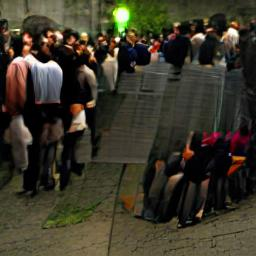

In [35]:
texts = [
    "berghain queue"
]
toks = clip.tokenize(texts, truncate=True)
H = perceptor.encode_text(toks.to(device)).float()
with torch.no_grad():
    z = net(H)
    z = clamp_with_grad(z, z_min.min(), z_max.max())
    xr = synth(model, z)
grid = torchvision.utils.make_grid(xr.cpu(), nrow=len(xr))
out_path = f"{output_path}/gen.jpg"
upscale(out_path)
torchvision.transforms.functional.to_pil_image(grid).save(out_path)
sz = 256
Image(out_path, width=sz*len(texts), height=sz)

# Interpolation video from a set of text prompts 

In [36]:
from base64 import b64encode
from IPython.display import HTML
nb_interm = 32 # nb of intermediate images between each successive text prompts
bs = 8 # reduce bs (batch size) if memory error
texts = [
  'fake shaman',
  'authentic shaman',
  'priest',
  'sinner',
]
toks = clip.tokenize(texts, truncate=True)
alpha = torch.linspace(0,1,nb_interm).view(-1,1).to(device)
feats = perceptor.encode_text(toks.to(device)).float()

H_list = []
for i in range(len(texts)-1):
  Hi = feats[i:i+1] * (1-alpha) + feats[i+1:i+2] * alpha
  H_list.append(Hi)
H = torch.cat(H_list)
xr_list = []
with torch.no_grad():
  for i in range(0, len(H), bs):
    z = net(H[i:i+bs])
    z = clamp_with_grad(z, z_min.min(), z_max.max())
    xr = synth(model, z)
    xr_list.append(xr.cpu())
xr = torch.cat(xr_list)
grid = torchvision.utils.make_grid(xr.cpu(), nrow=len(xr))
!rm -f *.jpg *.mp4
out_path = f"{output_path}/gen.png"
torchvision.transforms.functional.to_pil_image(grid).save(out_path)
upscale(out_path)
for i, img in enumerate(xr):
  filepath = f"{output_path}/image_{i:05d}.jpg"
  torchvision.transforms.functional.to_pil_image(img).save(filepath)
  upscale(filepath)
!ffmpeg -framerate 15 -pattern_type glob -i 'image*.jpg'  -c:v libx264 -r 30 -pix_fmt yuv420p video.mp4 1>&2 2>/dev/null
# Show video
mp4 = open("video.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=256 height=256 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

[Errno 2] No such file or directory: '/content/Real-ESRGAN'
/content/feed_forward_vqgan_clip
python3: can't open file 'inference_realesrgan.py': [Errno 2] No such file or directory
mv: '/content/output/gen.png' and '/content/output/gen.png' are the same file
/content
[Errno 2] No such file or directory: '/content/Real-ESRGAN'
/content
python3: can't open file 'inference_realesrgan.py': [Errno 2] No such file or directory
mv: cannot stat '/content/output/image_00000_out.jpg': No such file or directory
/content/feed_forward_vqgan_clip
[Errno 2] No such file or directory: '/content/Real-ESRGAN'
/content/feed_forward_vqgan_clip
python3: can't open file 'inference_realesrgan.py': [Errno 2] No such file or directory
mv: cannot stat '/content/output/image_00001_out.jpg': No such file or directory
/content
[Errno 2] No such file or directory: '/content/Real-ESRGAN'
/content
python3: can't open file 'inference_realesrgan.py': [Errno 2] No such file or directory
mv: cannot stat '/content/output/

FileNotFoundError: ignored

In [ ]:
Image("gen.png")